In [257]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers, activations
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras import regularizers, losses
from sklearn import preprocessing, decomposition
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.style as style
style.use('ggplot')

RANDOM_SEED = 42

In [258]:
df = pd.read_excel("Dados_Anomalias.xlsx")

df.head()

,Cyc Water,Mill Water,Mill Feed,PSI,Cyc Pressure (psi),Mill Power,Anomaly
0,223.812274,19.186624,202.823357,62.541316,0.612988,3335.920588,0
1,225.184535,19.186649,202.739986,62.434876,0.612922,3339.722789,0
2,225.185704,19.187493,202.273536,72.517052,0.615369,3344.942698,0
3,225.184088,19.187664,202.580639,80.587775,0.613380,3344.121925,0
4,223.329328,18.320862,202.743300,72.557990,0.606886,3352.125359,0


In [259]:
np.shape(df)

(542, 7)

In [260]:
def show_pca_df(df):
    x = df[df.columns[0:5]].to_numpy()
    y = df[df.columns[5]].to_numpy()

    x = preprocessing.MinMaxScaler().fit_transform(x)
    pca = decomposition.PCA(n_components=3)
    pca_result = pca.fit_transform(x)
    print(pca.explained_variance_ratio_)

    pca_df = pd.DataFrame(data=pca_result, columns=['pc_1', 'pc_2', 'pc_3'])
    pca_df = pd.concat([pca_df, pd.DataFrame({'label': y})], axis=1)

    ax = Axes3D(plt.figure(figsize=(8, 8)))
    ax.scatter(xs=pca_df['pc_1'], ys=pca_df['pc_2'], zs=pca_df['pc_3'], c=pca_df['label'], s=25)
    ax.set_xlabel("PC_1")
    ax.set_ylabel("PC_2")
    ax.set_zlabel("PC_3")
    plt.show()


[0.93113291 0.04323289 0.01668867]


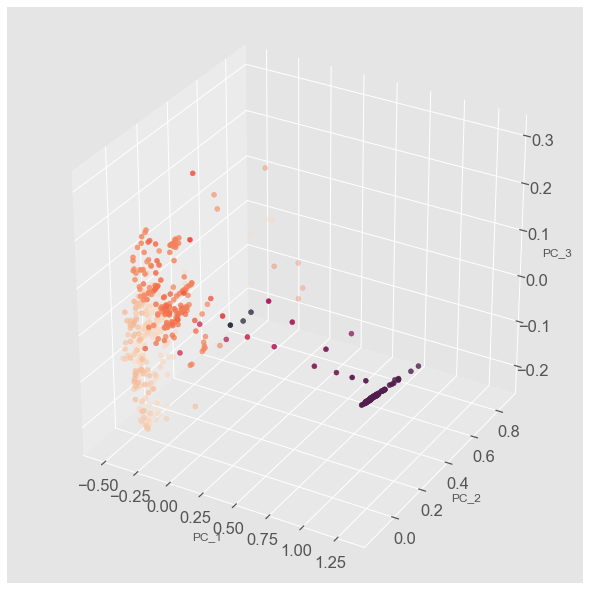

In [261]:
show_pca_df(df)

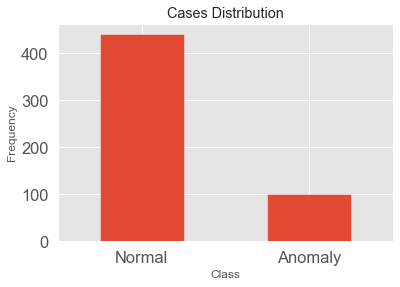

In [262]:
LABELS = ["Normal", "Anomaly"]
count_classes = pd.value_counts(df['Anomaly'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Cases Distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [263]:
anomalies = df[df.Anomaly == 1]
normal = df[df.Anomaly == 0]

In [264]:
anomalies.shape

(101, 7)

In [265]:
normal.shape

(441, 7)

In [266]:
df = df[df['Anomaly'] == 0] #Retirando os casos de anomalia, onde Anomaly == 1

In [267]:
df.head()

,Cyc Water,Mill Water,Mill Feed,PSI,Cyc Pressure (psi),Mill Power,Anomaly
0,223.812274,19.186624,202.823357,62.541316,0.612988,3335.920588,0
1,225.184535,19.186649,202.739986,62.434876,0.612922,3339.722789,0
2,225.185704,19.187493,202.273536,72.517052,0.615369,3344.942698,0
3,225.184088,19.187664,202.580639,80.587775,0.613380,3344.121925,0
4,223.329328,18.320862,202.743300,72.557990,0.606886,3352.125359,0


In [268]:
np.shape(df)

(441, 7)

In [269]:
df = np.array(df)

In [270]:
x_data = df[:,0:6]

In [271]:
input_dim = x_data.shape[1]
print(input_dim)

6


In [272]:
x_train, x_test = train_test_split(x_data, test_size=0.5, random_state=5)

In [273]:
mean = x_train.mean(axis=0)
x_train -= mean
std = x_train.std(axis=0)
x_train /= std

x_test -= mean
x_test /= std

In [274]:
encoder = tf.keras.models.Sequential(name='encoder')
encoder.add(layer=layers.Dense(units=10, activation=activations.tanh, input_shape=[input_dim]))
encoder.add(layers.Dropout(0.2))
encoder.add(layer=layers.Dense(units=5, activation=activations.tanh))
encoder.add(layer=layers.Dense(units=5, activation=activations.tanh))

decoder = tf.keras.models.Sequential(name='decoder')
decoder.add(layer=layers.Dense(units=5, activation=activations.tanh, input_shape=[5]))
decoder.add(layer=layers.Dense(units=10, activation=activations.tanh))
decoder.add(layers.Dropout(0.2))
decoder.add(layer=layers.Dense(units=input_dim, activation=activations.linear))

autoencoder = tf.keras.models.Sequential([encoder, decoder])


In [275]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_4 (Dense)              (None, 10)                60        
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 66        
Total params: 156
Trainable params: 156
Non-trainable params: 0
_________________________________________________________________


In [276]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                70        
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 30        
Total params: 155
Trainable params: 155
Non-trainable params: 0
_________________________________________________________________


In [277]:
from tensorflow.keras import backend as K
K.clear_session()

In [278]:
nb_epoch = 120
batch_size = 2

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['MSE'])

history = autoencoder.fit(x_train, x_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=False,
                    validation_data=(x_test, x_test),
                    verbose=0).history

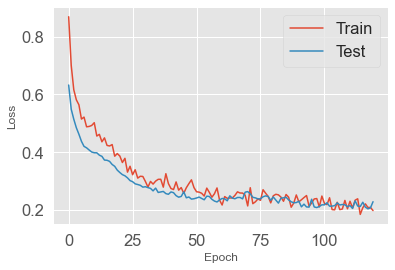

In [279]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right');

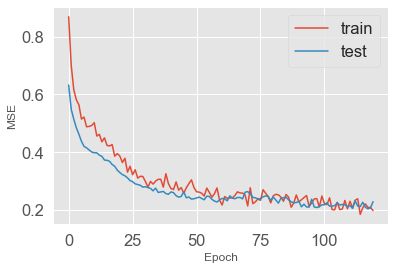

In [286]:
plt.plot(history['MSE'])
plt.plot(history['val_MSE'])
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [281]:
def normaliza(x_new):
    
    x_new[0][0] -= 183.4774
    x_new[0][1] -= 13.9945
    x_new[0][2] -= 158.544
    x_new[0][3] -= 63.351
    x_new[0][4] -= 0.3981
    x_new[0][5] -= 3069.158

    x_new[0][0] /= 81.18886
    x_new[0][1] /= 6.6099
    x_new[0][2] /= 74.7123
    x_new[0][3] /= 2.888
    x_new[0][4] /= 0.19312
    x_new[0][5] /= 293.1745
    
    return x_new

In [282]:
def MSE(X,Y):
    mse = 0
    n=len(X)
    for i in range(len(X)):
        mse += (X[i] - Y[i])**2
    return mse/n
        

In [283]:
x_test = []
x_test.append(np.array([[74.8505,5.3593,55.2195,68.9348,0.1255,2658.6988]]))
x_test.append(np.array([[230.7948,19.0728,199.5670,61.9917,0.4750,3096.6288]]))
x_test.append(np.array([[9.7484,0.2655,0.2059,62.4160,0.0069,2507.2545]]))
x_test.append(np.array([[220.0886,15.3509,181.2426,64.7993,0.4114,3074.2701]]))
y_test = []
              
for i in range(0,4):
    x_test[i] = normaliza(x_test[i])
    
    encoded_x = encoder.predict(x_test[i])
    decoded_y = decoder.predict(encoded_x)
    
    y_test.append(decoded_y)
    
    print("X=%s\nY=%s" % (x_test[i][0], y_test[i][0]))
    print("MSE #%s: %s \n" % (i+1, MSE(x_test[i][0], y_test[i][0]))) 

X=[-1.33795326 -1.30640403 -1.38296505  1.93344875 -1.41155758 -1.40005082]
Y=[-0.9557635 -1.0629247 -1.1976377  1.678177  -0.9706094 -0.9874954]
MSE #1: 0.1115830501804679 

X=[ 0.58280656  0.76828696  0.5490796  -0.47067175  0.39819801  0.09370119]
Y=[ 0.5131088   0.6663697   0.500724   -0.3959445   0.24264243  0.35164237]
MSE #2: 0.018983087481003632 

X=[-2.13981327 -2.07703596 -2.11930432 -0.32375346 -2.02568351 -1.91661792]
Y=[-1.4179252  -1.5878786  -1.865203   -0.25072914 -1.3100666  -1.6009791 ]
MSE #3: 0.24033879195810492 

X=[0.45093871 0.20520734 0.30381343 0.50148892 0.0688691  0.01743706]
Y=[0.59461856 0.24843001 0.43284628 0.16193247 0.12296452 0.3009264 ]
MSE #4: 0.03962544554925682 



In [284]:
print("Rel_MSE 1: %s" % (MSE(x_test[0][0], y_test[0][0]) / MSE(x_test[1][0], y_test[1][0])))
print("Rel_MSE 1: %s" % (MSE(x_test[2][0], y_test[2][0]) / MSE(x_test[3][0], y_test[3][0])))


Rel_MSE 1: 5.878024335721416
Rel_MSE 1: 6.065264090452921
